In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from math import pi, cos

import handcalcs.render
import forallpeople
from math import pi
from IPython.display import display, Markdown, Math
forallpeople.environment('structural', top_level = True)
%decimal_separator ,

In [2]:
# parâmetros para cálculo adimensional
# d1_h representa a razão d1/h
d1_h = .1
d2_h = .1
ℶ = 1/(1+d1_h)
ℵ = d2_h/(1-d1_h) 


#ω_tot = 1.0

#ω_1 = ω_tot * .5
#ω_2 = ω_tot * .5

In [3]:
%%render params
E_s = (200000 * N / mm ** 2).prefix('M')
γ_s = 1.15
f_yk = 500 * N/mm**2
f_tkcal = 525 * N/mm ** 2
f_yd = f_yk/γ_s
f_tdcal = f_tkcal/γ_s
ε_su = 0.025
ε_yd = f_yd/E_s
ε_c2u = 0.0035
ε_c2 = 0.002 # Deformação de início de esmagamento


<IPython.core.display.Latex object>

In [4]:
%%render params
ξ_23 = ε_c2u/(ε_c2u+ε_su)
ξ_lim = ε_c2u/(ε_c2u+ε_yd) #O mesmo que $ξ_{34}$

<IPython.core.display.Latex object>

In [5]:
#Cálculo da tensão do aço para problemas de flexão pelos parâmetros da DIN1045-1
def eval_σ_s(ε_s):
    if abs(ε_s)>0.025:   #data sanity check
        print("ε_s is invalid")
        σ_s = 'ERRO'
        return σ_s
    
    if 0 < ε_s <= ε_yd:
        σ_s = E_s * ε_s
    elif ε_yd < ε_s <= ε_su:
        σ_s = ((f_tdcal-f_yd)/(ε_su-ε_yd))*(ε_s-ε_yd)+f_yd
    elif - ε_yd < ε_s <= 0:
        σ_s = E_s * ε_s
    elif -ε_su < ε_s <= - ε_yd:
        σ_s = - f_yd
    else:
        σ_s = 'What?'
        print('ε_s_problema',ε_s)
    return σ_s

In [6]:
# função que produz um gráfico do diagrama σ-ε para o aço pelos valores DIN1045-1
def plot_steel_diagram():
    σ_s_list = []
    ε_s_list = []

    for i in range(-99,101):
        u = i/100
        ε_s = u * ε_su
        σ_s=eval_σ_s(ε_s)
        ε_s_list.append(ε_s)
        σ_s_list.append(float(σ_s))

    data={'σ_s':σ_s_list}

    dados = pd.DataFrame(data, index=ε_s_list)

    lines = dados.plot.line()

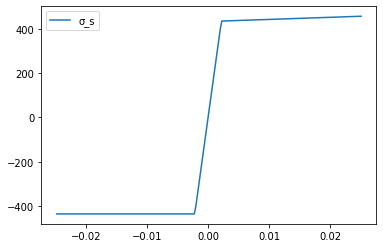

In [7]:
plot_steel_diagram()

In [8]:
def eval_α_R(ε):
    ε = -ε*1000 # O valor de entrada é o absoluto: precisa tornar neg e em %o
    if 0 >= ε >= -2:
        α_R = -ε/2 - (ε**2)/12
    elif -2 > ε >= -3.5:
        α_R = 1 + 2/(3*ε)
    elif ε > -3.5:
        print("INVALID ϵ value")
        return 0
    else:
        return 'WTF?'
    
    return α_R

In [9]:
def eval_ν_Ed_and_μ_Ed(ξ):
    flag_dom5 = False # Se True, vai mostrar os print statements.
    
    α_R = 0.81
    k_a = 0.416
    global dom
    
    if ξ == 'PureTension':
        dom = 'reta-a'
        ε_s1 = ε_su
        ε_s2 = ε_su 
        σ_s1 = abs(eval_σ_s(ε_s1)); σ_s2 = abs(eval_σ_s(ε_s2))
        ν_Ed = ω_1*1.05 + ω_2 *1.05
        μ_Ed = 0
        return ν_Ed, μ_Ed
    
    elif ξ == 'PureCompression':
        dom = 'reta-b'
        ε_s1 = -ε_yd
        ε_s2 = -ε_yd
        σ_s1 = abs(eval_σ_s(ε_s1)); σ_s2 = abs(eval_σ_s(ε_s2))
        ν_Ed = - (ω_tot + 1)
        μ_Ed = 0
        return ν_Ed, μ_Ed
    
    elif ξ<=0:
        dom = 'dom. 1'
        ε_s1 = ε_su
        ε_s2 = ε_su*(ℵ-ξ)/(1-ξ) 
        σ_s1 = abs(eval_σ_s(ε_s1)); σ_s2 = abs(eval_σ_s(ε_s2))
        ν_s1 = ω_1*σ_s1/f_yd 
        ν_s2 = ω_2*σ_s2/f_yd
        ν_c = 0
        μ_s1 = ω_1*(σ_s1/f_yd)*(1/2-d1_h)
        μ_s2 = -ω_2*(σ_s2/f_yd)*(1/2-d2_h)
        μ_c = 0
        
    elif 0<ξ<=ξ_23:
        dom = 'dom. 2'
        ε_s1 = ε_su
        ε_ctop = ε_su*(ξ/(1-ξ))
        α_R = eval_α_R(ε_ctop)
        # Para lidar com o caso da LN entre 0 e d2
        if 0<ξ<ℵ:
            ε_s2 = ε_su * (ℵ-ξ)/(1-ξ)
            s2=1
        if ℵ<=ξ<=ξ_23:
            ε_s2 = ε_su * (ξ-ℵ)/(1-ξ)
            s2=-1
        
        #print('ε_s2,ε_s1:',ε_s2,ε_s1)
        σ_s1 = abs(eval_σ_s(ε_s1)); σ_s2 = abs(eval_σ_s(ε_s2))
        ν_s1 = ω_1*σ_s1/f_yd 
        ν_s2 = s2*ω_2*σ_s2/f_yd #s2 controla o sinal
        ν_c = -α_R*ξ*(1-d1_h)
        μ_s1 = ω_1*(σ_s1/f_yd)*(1/2-d1_h)
        μ_s2 = -s2*ω_2*(σ_s2/f_yd)*(1/2-d2_h)
        μ_c = α_R*ξ*(1-d1_h)*(1/2-k_a*ξ*(1-d1_h))
        
    elif ξ_23<ξ<=1:
        if ξ_23<ξ<ξ_lim:
            dom = 'dom. 3'
        elif ξ_lim<=ξ<=1:
            dom = 'dom. 4'
        ε_s1 = ε_c2u*(1-ξ)/ξ
        ε_s2 = ε_c2u*(ξ-ℵ)/ξ
        σ_s1 = abs(eval_σ_s(ε_s1)); σ_s2 = abs(eval_σ_s(ε_s2))
        ν_s1 = + ω_1*σ_s1/f_yd 
        ν_s2 = - ω_2*σ_s2/f_yd
        ν_c = - α_R*ξ*(1-d1_h)
        μ_s1 = + ω_1*(σ_s1/f_yd)*(1/2-d1_h)
        μ_s2 = + ω_2*(σ_s2/f_yd)*(1/2-d2_h)
        μ_c = + α_R*ξ*(1-d1_h)*(1/2-k_a*ξ*(1-d1_h))
        
    elif 1<ξ:
        dom = 'dom. 5'
        aux = ((ε_c2u - ε_c2)/ε_c2u)
        ε_ctop = ε_c2 * ξ/(ξ - aux*ℶ)
        ε_cbot = ε_c2 * (ξ-ℶ)/(ξ - aux*ℶ) 
        ε_s1 = ε_c2 * (ξ-1)/(ξ-aux*ℶ)
        ε_s2 = ε_c2 * (ξ-ℵ)/(ξ-aux*ℶ)
        α_R1 = eval_α_R(ε_ctop)
        α_R2 = eval_α_R(ε_cbot)
        #ν_c = (α_R1-α_R2)*(ξ*ℶ)-α_R2
        ν_c1 = α_R1 * ξ * ℶ
        ν_c2 = α_R2 * (ξ*ℶ-1)
        ν_c = ν_c1 - ν_c2

        α_R = α_R1 + α_R2

        σ_s1 = abs(eval_σ_s(-ε_s1)); σ_s2 = abs(eval_σ_s(-ε_s2))

        ν_s1 = - ω_1*σ_s1/f_yd 
        ν_s2 = - ω_2*σ_s2/f_yd
        #ν_c = - α_R

        μ_s1 = + ω_1*(σ_s1/f_yd)*(1/2-d1_h)
        μ_s2 = - ω_2*(σ_s2/f_yd)*(1/2-d2_h)
        μ_c = - α_R*(1/2-k_a)

        if flag_dom5 == True:
            print('α_R1,α_R2:',α_R1,α_R2)
            print('ν_c1,ν_c2',ν_c1,ν_c2)        
            print('ε_ctop,ε_cbot:',ε_ctop*1000,ε_cbot*1000)
            print('ε_s1,ε_s2:',ε_s1,ε_s2)        
            print('σ_s1,σ_s2:',σ_s1,σ_s2)        
            print('ν_s1,ν,s2,ν_c',ν_s1,ν_s2,ν_c)
            print('μ_s1,μ,s2,μ_c',μ_s1,μ_s2,μ_c)

    
    ν_Ed = ν_s1 + ν_s2 + ν_c
    μ_Ed = μ_s1 + μ_s2 + μ_c
    return ν_Ed, μ_Ed
        


In [10]:
ω_tot = 2.0
ω_1 = .5*ω_tot
ω_2 = .5*ω_tot

pt0 = eval_ν_Ed_and_μ_Ed('PureCompression')
dom0 = dom

pt1 = eval_ν_Ed_and_μ_Ed(9999900000)
dom1 = dom

pt2 = eval_ν_Ed_and_μ_Ed(ξ_lim)
dom2 = dom


print(list(pt0), dom0, list(pt1), dom1, list(pt2), dom2)

[-3.0, 0] reta-b [-0.8978527450256182, -0.11200000003234796] dom. 5 [-0.4512134646962233, 0.9215977502066701] dom. 4


In [11]:
hell=eval_ν_Ed_and_μ_Ed(999999)
""" Antes
ε_s1,ε_s2: 0.001860759493670886 0.00209704641350211
σ_s1,σ_s2: 372.152 MPa 419.409 MPa
ν_s1,ν,s2,ν_c -0.8559493670886076 -0.9646413502109706 -0.81
μ_s1,μ,s2,μ_c 0.34237974683544303 -0.3858565400843883 -0.06804000000000002
"""
'º'

# α's ok
# ε's ok
# σ's ok
# ν ok..?
# Agora começar a procurar uma maneira mais inteligente de fazer essas coisas
# Valor de ν não está dando certo... enlouqueceu

'º'

In [12]:
print(eval_ν_Ed_and_μ_Ed(1))
print(dom)

(-1.7310529100529102, 0.49238356402116407)
dom. 4


PT0:  (-3.0, 0)
reta-b
PT1:  (-1.7310529100529102, 0.49238356402116407)
dom. 4
PT2:  (-0.4512134646962233, 0.9215977502066701)
dom. 4
PT3:  (0.8071929824561406, 0.5219562696214219)
dom. 2
ξ_23 ^Problematico
PTx:  (2.051322702634204, 0.019470918947443384)
dom. 2
^0.000001 Problematico
PT4:  (2.0513227513227514, 0.019470899470899472)
dom. 1
PT5: (2.1, 0)
reta-a


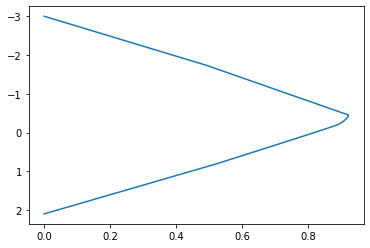

In [13]:
ν_Ed_list = []
μ_Ed_list = []
ξ_list =[]
dom_list =[]

PT0=eval_ν_Ed_and_μ_Ed('PureCompression'); print('PT0: ',PT0)
ν_Ed_list.append(PT0[0])
μ_Ed_list.append(PT0[1])
dom_list.append(dom), print(dom)

PT1=eval_ν_Ed_and_μ_Ed(1); print('PT1: ', PT1)
ν_Ed_list.append(PT1[0])
μ_Ed_list.append(PT1[1])
dom_list.append(dom), print(dom)


PT2=eval_ν_Ed_and_μ_Ed(ξ_lim); print('PT2: ', PT2)
ν_Ed_list.append(PT2[0])
μ_Ed_list.append(PT2[1])
dom_list.append(dom), print(dom)

for ξ in np.linspace(ξ_lim,ξ_23,50):
    ξ_list.append(ξ)
    res = eval_ν_Ed_and_μ_Ed(ξ)
    dom_list.append(dom)
    ν_Ed_list.append(res[0])
    μ_Ed_list.append(res[1])

"""PTx2=eval_ν_Ed_and_μ_Ed((.8*ξ_lim+.2*ξ_23)); print('PTx2: ', PTx2)
ν_Ed_list.append(PTx2[0])
μ_Ed_list.append(PTx2[1])
dom_list.append(dom), print(dom)"""

PT3=eval_ν_Ed_and_μ_Ed(ξ_23); print('PT3: ', PT3)
ν_Ed_list.append(PT3[0])
μ_Ed_list.append(PT3[1])
dom_list.append(dom), print(dom)
print('ξ_23 ^Problematico')

PTx=eval_ν_Ed_and_μ_Ed(0.000001); print('PTx: ', PTx)
ν_Ed_list.append(PTx[0])
μ_Ed_list.append(PTx[1])
dom_list.append(dom), print(dom)
print('^0.000001 Problematico')
# Problematico

PT4=eval_ν_Ed_and_μ_Ed(0); print('PT4: ', PT4)
ν_Ed_list.append(PT4[0])
μ_Ed_list.append(PT4[1])
dom_list.append(dom), print(dom)

PT5=eval_ν_Ed_and_μ_Ed('PureTension'); print('PT5:', PT5)
ν_Ed_list.append(PT5[0])
μ_Ed_list.append(PT5[1])
dom_list.append(dom), print(dom)

plt.plot(μ_Ed_list,ν_Ed_list)
plt.gca().invert_yaxis()



In [14]:
ν_Ed_list
μ_Ed_list

[0,
 0.49238356402116407,
 0.9215977502066701,
 0.9215977502066701,
 0.9213634137383498,
 0.9210760649802553,
 0.9207358318938118,
 0.9203428513919267,
 0.9198972701356675,
 0.9193992454175667,
 0.9188489461427471,
 0.9182465539207413,
 0.9175922642828543,
 0.9168862880422445,
 0.9161288528166264,
 0.9153202047367456,
 0.9144606103676136,
 0.913550358874075,
 0.9125897644677331,
 0.9115791691788373,
 0.9105189460046131,
 0.9094095024950629,
 0.9082512848488374,
 0.9070447826058846,
 0.9057905340408414,
 0.9044891323823651,
 0.9031412330098374,
 0.9017475618114487,
 0.900308924928368,
 0.8988262201607945,
 0.8973004503762415,
 0.8957327393424649,
 0.8941243505124604,
 0.8924767094242783,
 0.8907914305540798,
 0.8890703496907278,
 0.8795118794020654,
 0.8685042403355788,
 0.856763599834503,
 0.8442092381752998,
 0.8307470824957153,
 0.8162668264801299,
 0.8006382708795388,
 0.7837066273516412,
 0.7652864260194875,
 0.7451535171569208,
 0.7230344331662426,
 0.6985920352977876,
 0.67140583

In [15]:
PT0[0]

-3.0

In [16]:
PT1[0]

-1.7310529100529102

In [17]:
ε_s2_23 = ε_c2u * (ξ_23-ℵ)/ξ_23

In [18]:
ε_s2_23

0.00033333333333333294

In [19]:
ℵ*ε_su

0.0027777777777777783

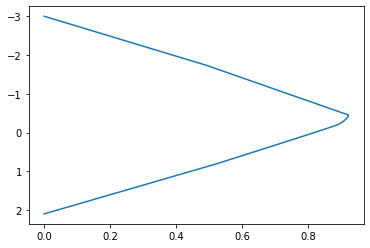

In [20]:
#Bloco para criar listas de valores de ν,μ
def generate_vals():
    global ν_Ed_list
    global μ_Ed_list
    
    ν_Ed_list = []
    μ_Ed_list = []
    ξ_list =[]
    dom_list =[]

    pure_trac = eval_ν_Ed_and_μ_Ed('PureTension')
    ν_Ed_list.append(pure_trac[0])
    μ_Ed_list.append(pure_trac[1])

    for ξ in np.linspace(-1,1,1000):
        ξ_list.append(ξ)
        res = eval_ν_Ed_and_μ_Ed(ξ)
        dom_list.append(dom)
        ν_Ed_list.append(res[0])
        μ_Ed_list.append(res[1])

    pure_comp = eval_ν_Ed_and_μ_Ed('PureCompression')
    ν_Ed_list.append(pure_comp[0])
    μ_Ed_list.append(pure_comp[1])

plt.plot(μ_Ed_list,ν_Ed_list)
plt.gca().invert_yaxis()

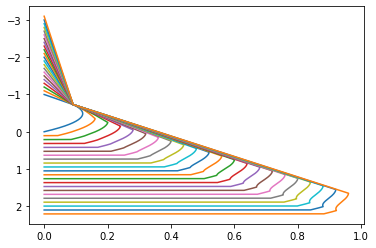

In [30]:
#plt.plot(ξ_list,ν_Ed_list)
#plt.plot(ξ_list,μ_Ed_list)

ω_tot_list = [.1*i for i in list(range(0,22))]

for ω_val in ω_tot_list:
    ω_1 = ω_val
    ω_2 = 0
    ω_tot = ω_1 + ω_2 
    
    generate_vals()
    plt.plot(μ_Ed_list,ν_Ed_list)

plt.gca().invert_yaxis()

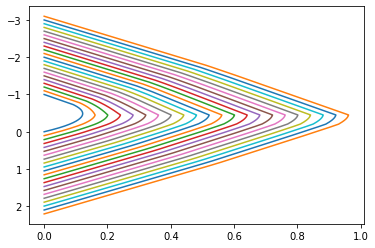

In [22]:
#plt.plot(ξ_list,ν_Ed_list)
#plt.plot(ξ_list,μ_Ed_list)

ω_tot_list = [.1*i for i in list(range(0,22))]

for ω_tot in ω_tot_list:
    ω_tot = ω_tot
    ω_1 = ω_tot * .5
    ω_2 = ω_tot * .5
    generate_vals()
    plt.plot(μ_Ed_list,ν_Ed_list)

plt.gca().invert_yaxis()

In [23]:
a = list(range(0,11))

In [24]:
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [25]:
ω_tot_list = [.1*i for i in list(range(0,10))]

In [26]:
ω_tot_list

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9]